In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm,tnrange
from SD import stochastic_descent

'''from quantum_state import i,hamiltonian_LA
from quantum_state import i, evolution_from_protocol, spectral_time_evolution, compute_fidelity
from qutip import basis, Bloch
from gif import qutip_qstate
from Qmodel import quantum_model
'''

import os
import pandas as pd

In [2]:
def correlation(matrix,h):
    '''
    Given a matrix this function computes the correlation quantity Q(T) as in the paper.
    Matrix must have dimension (n_protocols,lenght_of_protocol)    
    '''
    n_row = matrix.shape[0]
    n_col = matrix.shape[1] 
    
    mean_hx = np.array([matrix[:,i].mean() for i in range(n_col)]) #mean over all protocols at fixed time
    avg_over_h = np.array([np.array([ (matrix[i,j]-mean_hx[j])**2 for i in range(n_row)]).sum()/n_row for j in range(n_col)])
    avg_over_Nt = (1/((h*h)*n_col))*(avg_over_h.sum())
    return  avg_over_Nt

In [3]:
#Starting qstates and their normalization
qstart = np.array([-1/2 - (np.sqrt(5))/2 ,1], dtype=complex)
qtarget = np.array([+1/2 + (np.sqrt(5))/2 ,1], dtype=complex)
qstart=qstart/np.sqrt(np.vdot(qstart,qstart))
qtarget=qtarget/np.sqrt(np.vdot(qtarget,qtarget))
print("qstart",qstart)

qstart [-0.85065081+0.j  0.52573111+0.j]


In [4]:
#SD parameters
L = 1
h = 4
h_list = [-h,h]
dt = 0.005
#nsteps = int(100)
iterations = int(1e3)
percentage_flips = 1
exp_decay = False
metropolis = False

print("-------------PARAMETERS for SD---------------")
print("Number of qubits (L):", L)
print("Magnetic fields(h):", h)
print("Timesteps (dt):", dt)
print("Iterations:", iterations)
print("Percentage of flips:", percentage_flips)
print("Exp decays of flips:", exp_decay)
print("Metropolis:", metropolis)
print("\n")
print("\n")

#parameters for Fig. pag 2 ---- Calculation of fidelity and Q(T)
#step_in_time_grid = 0.1
times_first_part=np.arange(0,1,0.1)
times_second_part=np.arange(1,4.1,0.1)
times=np.concatenate([times_first_part,times_second_part])
#times = np.arange(0,4,0.1)#+step_in_time_grid,step=step_in_time_grid)
iter_for_each_time = 20

fidelity_for_txt = []
print("--------------PARAMETERS for Plotting-------------")
print("Timegrid:", times)
print("Repetition at each timestep:", iter_for_each_time)
print("\n")

params_dict = {"L":L, "h":h, "iterations":iterations, "percentage_flips":percentage_flips, 
               "exp_decay":exp_decay, "metropolis":metropolis, "times":times, "iter_for_each_time": iter_for_each_time}
params_df = pd.DataFrame.from_dict(params_dict, orient="index")

-------------PARAMETERS for SD---------------
Number of qubits (L): 1
Magnetic fields(h): 4
Timesteps (dt): 0.005
Iterations: 1000
Percentage of flips: 1
Exp decays of flips: False
Metropolis: False




--------------PARAMETERS for Plotting-------------
Timegrid: [0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1.  1.1 1.2 1.3 1.4 1.5 1.6 1.7
 1.8 1.9 2.  2.1 2.2 2.3 2.4 2.5 2.6 2.7 2.8 2.9 3.  3.1 3.2 3.3 3.4 3.5
 3.6 3.7 3.8 3.9 4. ]
Repetition at each timestep: 20




In [5]:
#UNCOMMENT TO RUN
print("WARNING! Attenzione a non sovrascrivere")

#save run parameters and date in custom named folder
#os.chdir("C:\Users\GUIDA\Desktop\CODE_MONTANGERO\SD_WITH_REPLACEMENT")
custom_name_dir = "data_test_new_class"
os.system("mkdir "+custom_name_dir)
os.system("mkdir "+custom_name_dir+"/protocols_m")
params_df.to_csv(custom_name_dir+"/parameters_m.csv")

intermediete_result = True

for T in times[1:]:
    temp_fid = []
    best_prot = []
    print("Running time:", T)
    for _ in tnrange(iter_for_each_time):

        best_protocol, fidelity = stochastic_descent(qstart, qtarget, L, T, dt, 
                        flips = percentage_flips, field_list = h_list,
                        beta=0.6, exp_decay_flip=exp_decay,
                        metropolis_choice=False, verbose = True, check_norm = True)

        temp_fid.append(fidelity[-1]) #at fixed T we will have "iter_for_each_time" evaluations of fidelity
        best_prot.append(best_protocol) #all iter_for_each_time best protocols are stored in this variable 
                                        #and saved when new rounf over T starts
    fidelity_for_txt.append(temp_fid) #fidelity evaluations are stored in the same "fidelity_fot_txt"
                                      #variable that will have dimension len(times)*iter_for_each_time
    best_prot = np.array([best_prot])
    with open(custom_name_dir +'/protocols_m/testT'+str(round(T, 2))+'.npy', 'wb') as f:
        np.save(f,best_prot)
    f.close()
    
    if intermediete_result and T !=0: #if T = 0 q cannot be computed
        data = np.load(custom_name_dir +'/protocols_m/testT'+str(round(T, 3))+'.npy')[0,:,:] #first dimension is redundant 
        print("Mean fidelity:", np.array(temp_fid).mean())
        print("Q value is:", correlation(data, h))
        print("\n")
        
#fidelity values are saved at the end
np.savetxt(custom_name_dir + '/fidelity_m.txt', fidelity_for_txt, delimiter = ',',header="Matrix with as entries the values of fidelity dimension times x iterations")


WARNING! Attenzione a non sovrascrivere
Running time: 0.1



Mean fidelity: 0.2059326134542155
Q value is: 0.099


Running time: 0.2



Mean fidelity: 0.22345528137742993
Q value is: 0.049500000000000016


Running time: 0.30000000000000004



Mean fidelity: 0.2513571588338014
Q value is: 0.05833333333333335


Running time: 0.4



Mean fidelity: 0.2880170614306152
Q value is: 0.05825


Running time: 0.5



Mean fidelity: 0.3311674803022734
Q value is: 0.06820000000000001


Running time: 0.6000000000000001



Mean fidelity: 0.37835912142880884
Q value is: 0.108


Running time: 0.7000000000000001



Mean fidelity: 0.42744079892546205
Q value is: 0.15742857142857142


Running time: 0.8



Mean fidelity: 0.477108512285118
Q value is: 0.23687500000000006


Running time: 0.9



Mean fidelity: 0.5269148058797922
Q value is: 0.3224444444444445


Running time: 1.0



Mean fidelity: 0.5766421275337253
Q value is: 0.3779


Running time: 1.1



Mean fidelity: 0.6255754684119113
Q value is: 0.4150909090909091


Running time: 1.2000000000000002



Mean fidelity: 0.6731606898452667
Q value is: 0.4595


Running time: 1.3000000000000003



Mean fidelity: 0.7190884880027368
Q value is: 0.5011538461538462


Running time: 1.4000000000000004



Mean fidelity: 0.762737502612576
Q value is: 0.5119285714285714


Running time: 1.5000000000000004



Mean fidelity: 0.8039278096530349
Q value is: 0.5480666666666667


Running time: 1.6000000000000005



Mean fidelity: 0.8419651357797443
Q value is: 0.5755


Running time: 1.7000000000000006



Mean fidelity: 0.8766350372327569
Q value is: 0.5879411764705883


Running time: 1.8000000000000007



Mean fidelity: 0.907440158351523
Q value is: 0.599


Running time: 1.9000000000000008



Mean fidelity: 0.9342490478741527
Q value is: 0.6320526315789474


Running time: 2.000000000000001



Mean fidelity: 0.9567383760771111
Q value is: 0.6429


Running time: 2.100000000000001



Mean fidelity: 0.9746469058395949
Q value is: 0.6564285714285716


Running time: 2.200000000000001



Mean fidelity: 0.9879403211670349
Q value is: 0.6810909090909092


Running time: 2.300000000000001



Mean fidelity: 0.9961689138222967
Q value is: 0.7065652173913044


Running time: 2.4000000000000012



Mean fidelity: 0.9996182887838115
Q value is: 0.7381041666666668


Running time: 2.5000000000000013



Mean fidelity: 0.9999802721195863
Q value is: 0.7835000000000001


Running time: 2.6000000000000014



Mean fidelity: 0.999985460551445
Q value is: 0.8474807692307694


Running time: 2.7000000000000015



Mean fidelity: 0.9999852500912437
Q value is: 0.8808703703703705


Running time: 2.8000000000000016



Mean fidelity: 0.9999862165178905
Q value is: 0.9073571428571429


Running time: 2.9000000000000017



Mean fidelity: 0.999985142641167
Q value is: 0.9338103448275862


Running time: 3.0000000000000018



Mean fidelity: 0.9999849013182001
Q value is: 0.9450666666666667


Running time: 3.100000000000002



Mean fidelity: 0.9999850209902841
Q value is: 0.9583870967741936


Running time: 3.200000000000002



Mean fidelity: 0.9999824783743554
Q value is: 0.9471406250000002


Running time: 3.300000000000002



Mean fidelity: 0.9999796620891364
Q value is: 0.9462424242424242


Running time: 3.400000000000002



Mean fidelity: 0.9999762531508635
Q value is: 0.9438529411764707


Running time: 3.500000000000002



Mean fidelity: 0.9999764619564135
Q value is: 0.9295857142857143


Running time: 3.6000000000000023



Mean fidelity: 0.9999822950457429
Q value is: 0.9226944444444447


Running time: 3.7000000000000024



Mean fidelity: 0.9999809318754549
Q value is: 0.9125405405405406


Running time: 3.8000000000000025



Mean fidelity: 0.9999781603659097
Q value is: 0.9122368421052632


Running time: 3.9000000000000026



Mean fidelity: 0.9999842669260802
Q value is: 0.9107435897435899


Running time: 4.000000000000003



Mean fidelity: 0.9999839590195945
Q value is: 0.8930375000000002




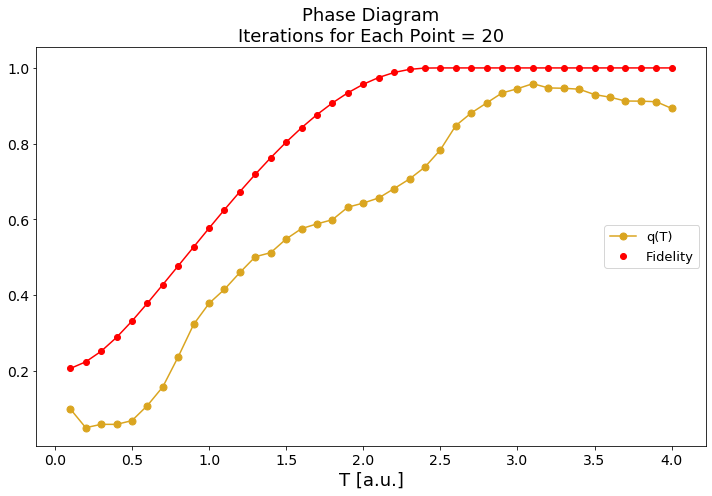

In [6]:
#PLOT 
#os.chdir("C:\Users\GUIDA\Desktop\CODE_MONTANGERO\SD_WITH_REPLACEMENT")
q=[]
for T in times[1:]:
    
    data = np.load(custom_name_dir +"/protocols_m/testT"+str(round(T, 2))+".npy")[0,:,:] #first dimension is redundant 
    #!warning: correlation normalization term musb be changed according to field values
    q.append(correlation(data,h))
    
loaded_fidelity = pd.read_csv(custom_name_dir +'/fidelity_m.txt', skiprows=1,header=None)
#loaded_fidelity = loaded_fidelity.loc[(loaded_fidelity.index % 19 == 0) & (loaded_fidelity.index > 0)]

#q[0]=0
fig, ax = plt.subplots(figsize=(10,7))
#plot Fidelity values
ax.errorbar(times[1:],loaded_fidelity.mean(axis=1).values, yerr=loaded_fidelity.std(axis=1).values, color="r")
ax.scatter(times[1:],loaded_fidelity.mean(axis=1).values,color='r',label="Fidelity")
#plot Q values
ax.plot(times[1:], q, marker="o", color="goldenrod", markersize=7, label="q(T)")


ax.set_title(r"Phase Diagram"+"\n"+"Iterations for Each Point = "+str(iter_for_each_time), fontsize=18)
ax.set_xlabel("T [a.u.]", fontsize=18)
#ax.set_ylabel(r" $Fidelity$", fontsize=18)
ax.tick_params(axis='both', which='major', labelsize=14)
ax.legend(fontsize=13, loc=5)
ax.grid()
fig.tight_layout()
fig.savefig("phase_diagram.pdf")
plt.show()